# Wine Quality Prediction Project

## Goal:
- Discover features that affect wine quality
- Use features to develop a machine learning model to predict the quality of wine on a scale of 1-10

# Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import wrangle as w
import explore as e
# import model as m
import evaluate as ev

from scipy.stats import pearsonr, spearmanr

import warnings
warnings.filterwarnings("ignore")

np.random.seed(123)

# Acquire
- Data acquired from [data.world](https://data.world/food/wine-quality)
- Downloaded two separate .csv files: 1 for red wine, 1 for white wine
- Merged the .csv files into a a single dataframe
- Added one column, wine_type, after combining csv files to indicate red or white wine
- It contained 6,497 rows and 13 columns before cleaning
    - 1599 rows were red wines
    - 4898 rows were white wines
- Each row represents a single vintage of wine
- Each column represents a chemical quality of the wines

# Prepare
- Did not remove any columns
- Did not rename any columns
- Checked for nulls - no null values found
- Checked that column data types were appropriate
- Outliers: used IQR method and 2 for the multiplier value:
    - IQR = Q3 - Q1;  For each column: removed (Q1 - 2 * IQR) AND removed (Q3 + 2 * IQR)
    - 867 rows removed
    - Began with 6,497
    - Ended with 5,630
- Encoded categorical variables
- Split data into train, validate, and test (60/20/20)
- Scaled continuous variables

# Data Dictionary

| Feature | Definition (measurement)|
|:--------|:-----------|
|Fixed Acidity| The fixed amount of tartaric acid. (g/L)|
|Volatile Acidity| A wine's acetic acid; (High Volatility = High Vinegar-like smell). (g/L)|
|Citric Acid| The amount of citric acid; (Raises acidity, Lowers shelf-life). (g/L)|
|Residual Sugar| Leftover sugars after fermentation. (g/L)|
|Chlorides| Increases sodium levels; (Affects color, clarity, flavor, aroma). (g/L)|
|Free Sulfur Dioxide| Related to pH. Determines how much SO2 is available. (Increases shelf-life, decreases palatability). (mg/L)|
|Total Sulfur Dioxide| Summation of free and bound SO2. (Limited to 350ppm: 0-150, low-processed, 150+ highly processed). (mg/L)|
|Density| Between 1.08 and 1.09. (Insight into fermentation process of yeast growth). (g/L)|
|pH| 2.5: more acidic - 4.5: less acidic (range)|
|Sulphates| Added to stop fermentation (Preservative) (g/L)|
|Alcohol| Related to Residual Sugars. By-product of fermentation process (vol%)|
|Quality (Target)| Score assigned between 0 and 10; 0=low, 10=best|
|Wine Type| Red or White|

In [2]:
# acquire and prepare wine data
df = w.wrangle_wine()

Total of rows originally: 6497
Total of rows removed: 867
New total of rows: 5630


In [3]:
df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality,wine_type_white_wine
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5,0
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5,0
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7,0


In [4]:
# split into train/validate/test datasets (tr/val/ts)
tr, val, ts = w.get_split(df)

Train: (3378, 13)
Validate: (1126, 13)
Test: (1126, 13)


# A brief look at the data

In [5]:
tr.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality,wine_type_white_wine
2980,5.7,0.43,0.30,5.7,0.039,24.0,98.0,0.99200,3.54,0.61,12.3,7,1
4035,6.9,0.43,0.28,9.4,0.056,29.0,183.0,0.99594,3.17,0.43,9.4,5,1
3741,7.5,0.26,0.52,13.2,0.047,64.0,179.0,0.99820,3.10,0.46,9.0,5,1
4485,6.6,0.41,0.31,1.6,0.042,18.0,101.0,0.99195,3.13,0.41,10.5,5,1
5778,6.9,0.24,0.40,15.4,0.052,81.0,198.0,0.99860,3.20,0.69,9.4,5,1


## A summary of the data

In [6]:
tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3378 entries, 2980 to 4990
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         3378 non-null   float64
 1   volatile_acidity      3378 non-null   float64
 2   citric_acid           3378 non-null   float64
 3   residual_sugar        3378 non-null   float64
 4   chlorides             3378 non-null   float64
 5   free_sulfur_dioxide   3378 non-null   float64
 6   total_sulfur_dioxide  3378 non-null   float64
 7   density               3378 non-null   float64
 8   ph                    3378 non-null   float64
 9   sulphates             3378 non-null   float64
 10  alcohol               3378 non-null   float64
 11  quality               3378 non-null   int64  
 12  wine_type_white_wine  3378 non-null   uint8  
dtypes: float64(11), int64(1), uint8(1)
memory usage: 346.4 KB


In [7]:
tr.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality,wine_type_white_wine
count,3378.000000,3378.000000,3378.000000,3378.000000,3378.000000,3378.000000,3378.000000,3378.000000,3378.000000,3378.000000,3378.000000,3378.000000,3378.000000
mean,6.996137,0.318283,0.303535,5.641933,0.048866,31.185465,120.457075,0.994345,3.219982,0.511578,10.541462,5.867377,0.818532
std,0.960999,0.136004,0.118204,4.723342,0.017296,16.269405,52.878207,0.002875,0.154876,0.122579,1.213733,0.870771,0.385463
min,3.900000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.250000,8.400000,3.000000,0.000000
25%,6.400000,0.220000,0.240000,1.800000,0.037000,18.000000,88.000000,0.992000,3.110000,0.420000,9.500000,5.000000,1.000000
50%,6.900000,0.280000,0.300000,3.600000,0.045000,30.000000,121.000000,0.994400,3.210000,0.500000,10.400000,6.000000,1.000000
75%,7.500000,0.380000,0.370000,8.500000,0.056000,42.000000,156.000000,0.996600,3.320000,0.587500,11.400000,6.000000,1.000000
max,10.200000,0.745000,0.630000,20.800000,0.102000,87.000000,282.000000,1.001960,3.720000,0.920000,14.000000,9.000000,1.000000


# Explore

## What is the distribution of the target?)
- NOTE: this question is more of a look at the data, not a stats test question

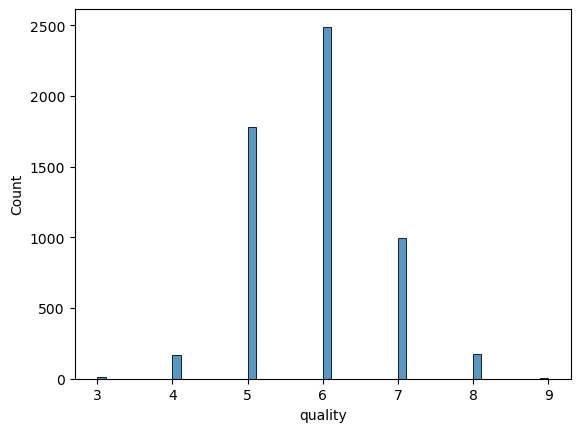

In [8]:
# get a histplot of quality
sns.histplot(df.quality)
plt.show()

## Question 1: Is alcohol associated with quality?

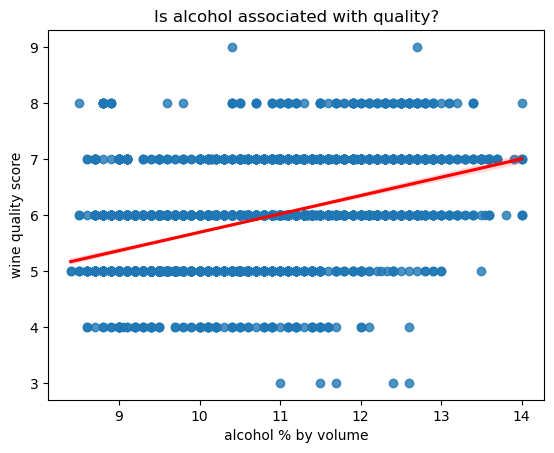

In [9]:
# Visualize: get a regplot of alcohol vs quality on train
e.get_alcohol_qual_plot(tr, 'alcohol', 'quality')

### Analyze alcohol vs quality with stats
- $H_0$: There is NO relationship between alcohol and quality
- $H_a$: There IS a relationship
- $\alpha$ = .05
    - Utilize spearmanr - we are comparing continuous variables, normally distributed, but UNequal variance

In [10]:
# get the stats from a pearsonr test on alcohol vs quality
spearmanr(tr.alcohol, tr.quality)

SpearmanrResult(correlation=0.46234896005122295, pvalue=1.456181106276295e-178)

### Summarize
- p is < $\alpha$, so we can reject the $H_0$ which suggest the $H_a$, i.e. there IS a relationship between alcohol and quality: as alcohol by volume increases, quality increases in the dataset

## Question 2: Are chloride levels associated with quality?)

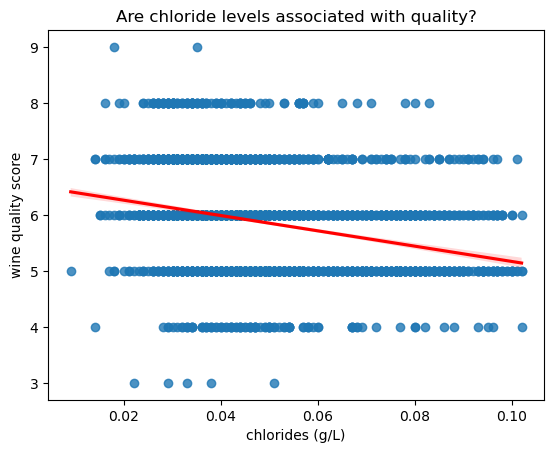

In [11]:
# Visualize: get a regplot of chlorides vs quality
e.get_chloride_qual_plot(tr, 'chlorides', 'quality')

### Analyze chlorides vs quality with stats
- $H_0$: There is NO relationship between chlorides and quality
- $H_a$: There IS a relationship
- $\alpha$ = .05
    - Utilize spearmanr - we are comparing continuous variables, normally distributed, but UNequal variance

In [12]:
# get the stats from a pearsonr test on chlorides vs quality
spearmanr(tr.chlorides, tr.quality)

SpearmanrResult(correlation=-0.3145155116581846, pvalue=1.9029656621476643e-78)

### Summarize
- p is < $\alpha$, so we can reject the $H_0$ which suggest the $H_a$, i.e. there IS a relationship between chlorides and quality: a lower value for chlorides correlates with an increase in quality

## Question 3 Is residual_sugar associated with quality?

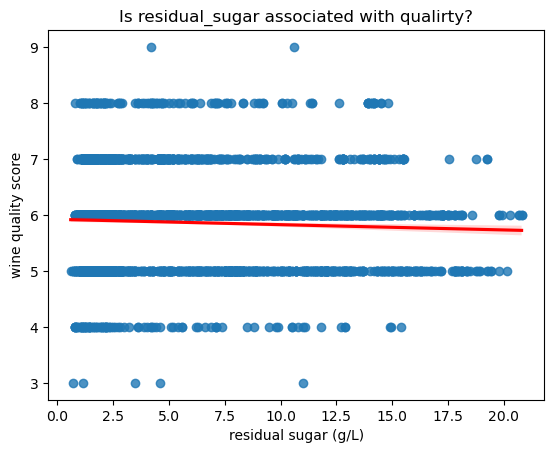

In [13]:
# Visualize: get a regplot of residual_sugar vs quality on train
e.get_res_sugar_quality_plot(tr, 'residual_sugar', 'quality')

### Analyze residual_sugar vs quality with stats
- $H_0$: There is NO relationship between residual_sugar and quality
- $H_a$: There IS a relationship
- $\alpha$ = .05
    - Utilize spearmanr - we are comparing continuous variables, normally distributed, but UNequal variance

In [14]:
# get the stats from a pearsonr test on chlorides vs quality
spearmanr(tr.residual_sugar, tr.quality)

SpearmanrResult(correlation=-0.029565525964640713, pvalue=0.08577753023737957)

### Summarize
- p is > $\alpha$, so we CANNOT reject the $H_0$ i.e. there is NOT a relationship between residual_sugar and quality

## Question 4 Is alcohol associated with density?
- Chemistry knowledge suggest these two features are very closely related, and therefore we should, perhaps, only send one in to our models

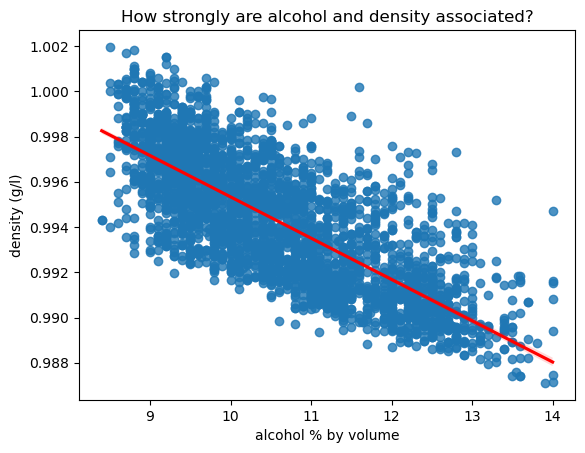

In [15]:
# Visualize: get a regplot of alcohol vs density on train
e.get_alcohol_density_plot(tr, 'alcohol', 'density')

### Analyze alcohol vs density with stats
- $H_0$: There is NO relationship between alcohol and density
- $H_a$: There IS a relationship
- $\alpha$ = .05
    - Utilize spearmanr - we are comparing continuous variables, normally distributed, but UNequal variance

In [16]:
# get the stats from a pearsonr test on alcohol vs density
spearmanr(tr.alcohol, tr.density)

SpearmanrResult(correlation=-0.7729668005975888, pvalue=0.0)

### Summarize
- p is < $\alpha$, so we can reject the $H_0$ which suggest the $H_a$, i.e. there IS a relationship between alcohol and density; furthermore, the correlation coefficient is -0.77, i.e. highly correlated (closer to -1 is more correlated)

## Exploration Summary
* No feature had a strong correlation with quality by itself; alcohol was the strongest with a .46 correlation coefficient
* However, most features had some relationship with quality by themselves (stats tests for other features completed in separate working notebook)
* density was closely correlated with alcohol
* PUT SOMETHING IN HERE ABOUT CLUSTERS


### Features we are moving to modeling with
* fixed_acidity
* volatile_acidity
* citric_acid
* chlorides
* free_sulfur_dioxide
* total_sulfur_dioxide
* ph
* sulphates
* alcohol
* wine_type

### Features we are, initially, not moving to modeling with
* residual_sugar
* density

# Modeling
* Evaluation Metrics (example: I will use R^2 and Root Mean Square Error (RMSE) as my evaluation metrics)
    * for R^2, the value is in the range 0-1; closer to 1.0 is better; baseline is 0.0
    * for RMSE, the lower the value the better; baseline is xxx
* The average target is xxx which is the baseline prediction
* I will evaluate x different model types and various hyperparameter configurations
    * (Example: The four model types are Ordinary Least Squares (OLS), LassoLars, Polynomial Regression, Generalized Linear Model (GLM))
* Models will be evaluated on train and validate data
* The model that performs the best will then be evaluated on test

In [17]:
## prep data for modeling

# get X y splits for modeling
target = 'quality'
X_tr, X_val, X_ts, y_tr, y_val, y_ts, to_scale, baseline = w.get_Xs_ys_to_scale_baseline(tr, val, ts, target)

# scaling continuous variable columns for use in modeling
X_tr_sc, X_val_sc, X_ts_sc = w.scale_data(X_tr,X_val,X_ts,to_scale)

Baseline Prediction (mean of quality) = 5.867377146240379


## Comparing models - All features EXCEPT residual_sugar and density
* Also running OLS on top 3 RFE features

In [18]:
# getting machine learning model metrics for features deemed useful in explore
to_model_cols = list(X_tr_sc.drop(columns=['residual_sugar', 'density']).columns)
w.display_model_metrics(baseline, tr[to_model_cols], y_tr, y_val, y_ts, X_tr_sc[to_model_cols], X_val_sc[to_model_cols], X_ts_sc[to_model_cols])

,model,rmse train,rmse validate,R2 validate
0,baseline,0.870642,,0.000000
1,ols with RFE-top-3 features,0.743719,0.737112,0.251331
2,ols,0.734863,0.729541,0.266633
3,lars,0.870642,0.852255,-0.000832
4,poly_2D,0.687791,0.70963,0.306118
5,glm,0.845940,0.828322,0.054589


* All models, except for Lars beat baseline

## Comparing models - All features
* Also running OLS on top 3 RFE features

In [19]:
# get model metrics for all features
w.display_model_metrics(baseline, tr, y_tr, y_val, y_ts, X_tr_sc, X_val_sc, X_ts_sc)

,model,rmse train,rmse validate,R2 validate
0,baseline,0.870642,,0.000000
1,ols with RFE-top-3 features,0.745488,0.732004,0.261672
2,ols,0.726417,0.720004,0.285680
3,lars,0.870642,0.852255,-0.000832
4,poly_2D,0.672154,0.695087,0.334266
5,glm,0.841822,0.824497,0.063299


* Using all features led to slightly better models
* Polynomial Regression, with degrees=2, is the best model

# Clustering
* Before we move to test, we will see if clustering may improve these models

## Cluster 1 - Density-Chlorides

In [20]:
tr, val, ts, X_tr, X_val, X_ts, y_tr, y_val, y_ts, to_scale, baseline, X_tr_sc, X_val_sc, X_ts_sc, X_tr2, y_tr2 = ev.density_chlorides_cluster(df)

Train: (3378, 13)
Validate: (1126, 13)
Test: (1126, 13)
Baseline Prediction (mean of quality) = 5.867377146240379


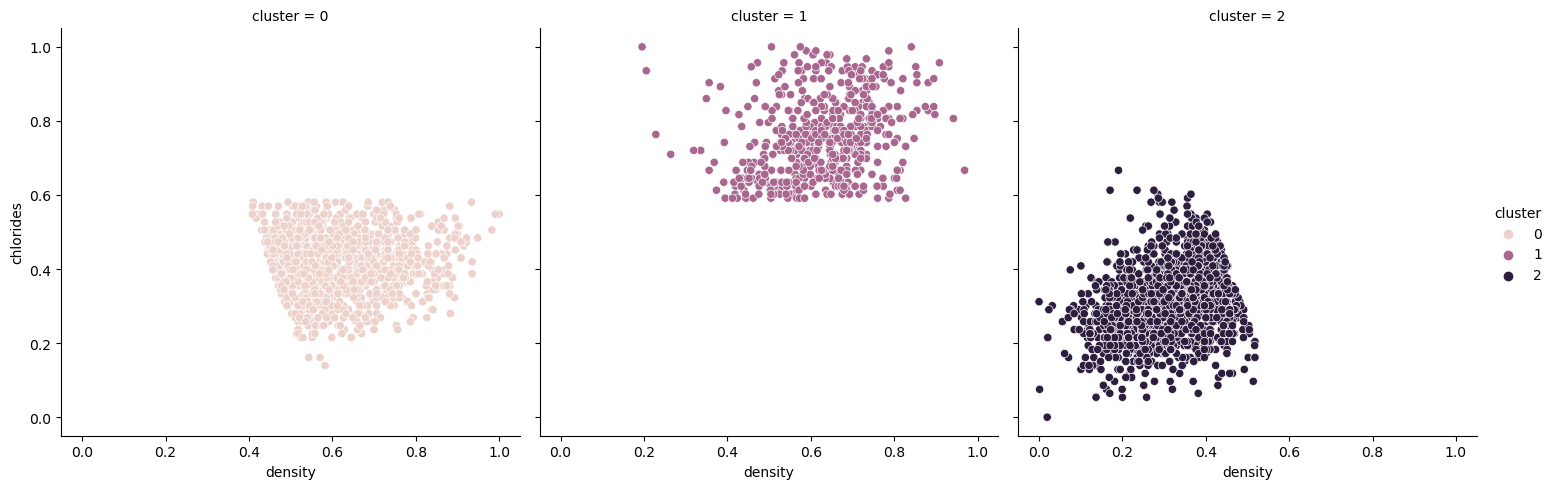

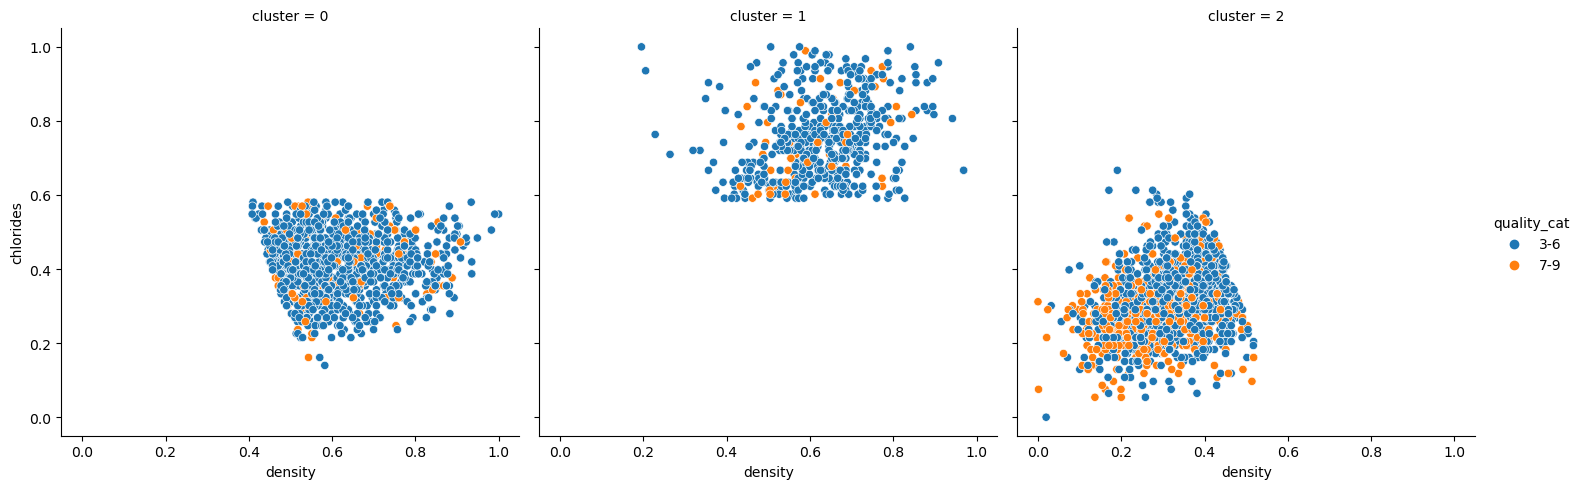

In [21]:
# Display cluster #1
ev.density_chlorides_cluster_plot(X_tr2, y_tr2)

* The cluster plot of density-chlorides splits into 3 sections in the bottom it hues on wine-quality. In the bottom right you'll see a higher concentration of better quality wines. We will attempt to run it throught the models.

## Cluster 2 Alcohol-Residual Sugar

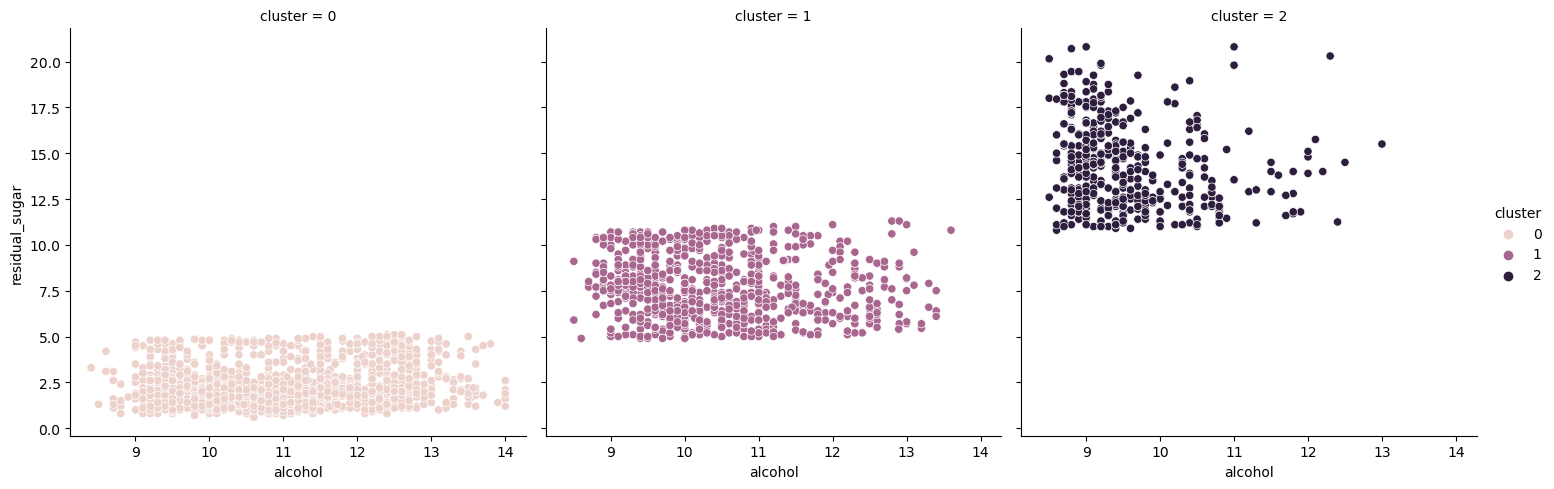

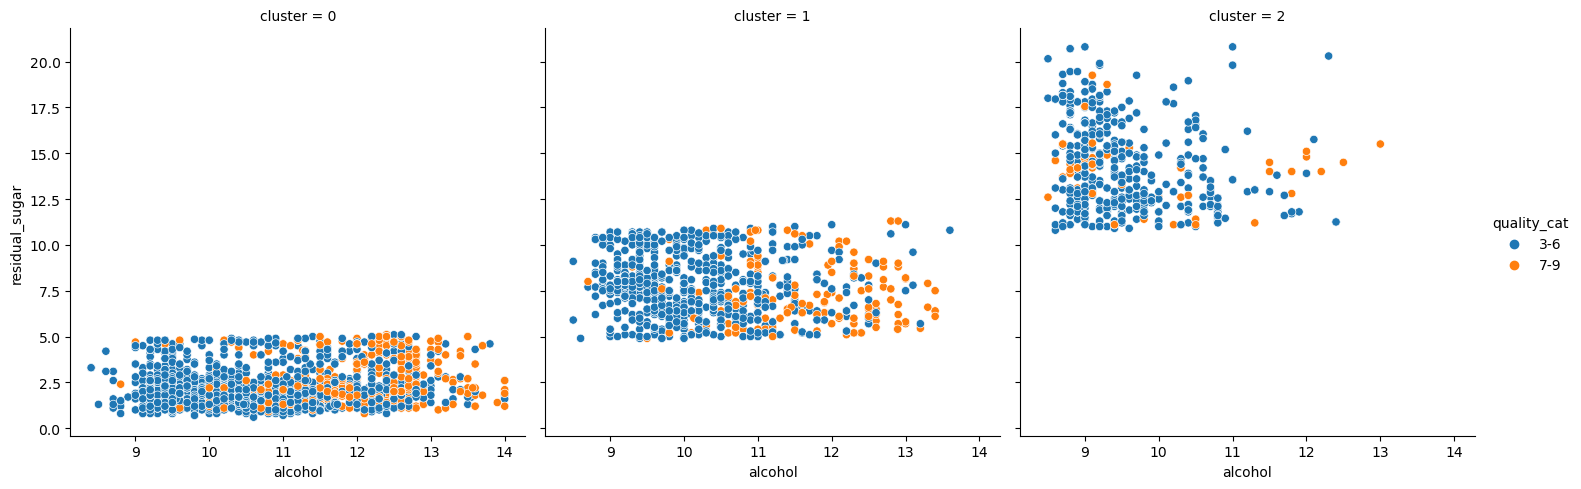

In [22]:
# Display cluster #2
ev.plot_cluster_2(X_tr, y_tr)

* The cluster plot of alcohol-residual sugar splits into 3 sections in the bottom as it hues on wine-quality. No noticable clusters.

## Cluster 3 Sulfur Dioxide-Residual Sugar

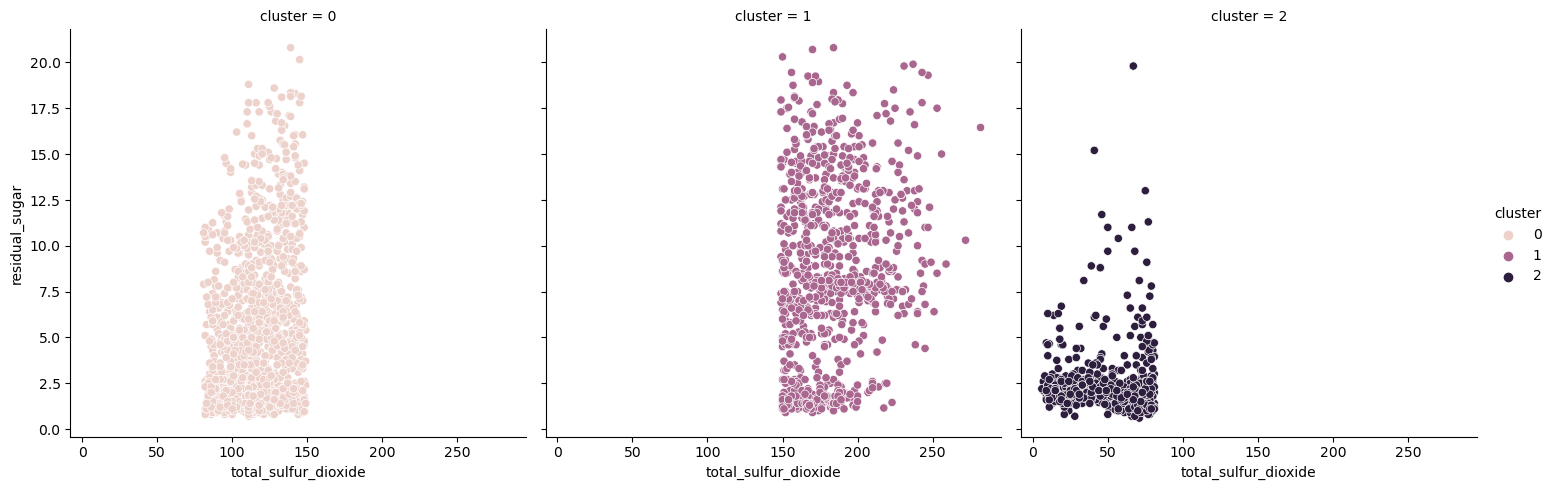

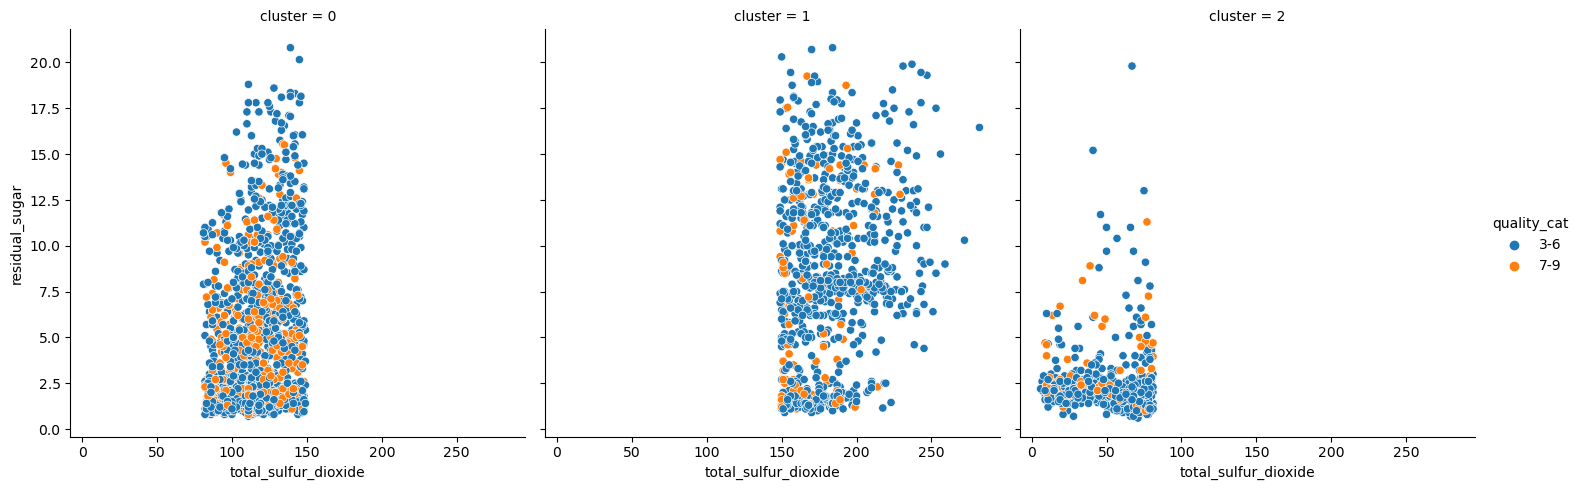

In [23]:
# Display cluster #3
ev.plot_cluster_3(X_tr, y_tr)

* The cluster plot of total sulfur dioxide-residual sugar splits into 3 sections in the bottom as it hues on wine-quality. No noticable clusters.

## Comparing models with best cluster

In [24]:
# get model results
ev.get_metrics_with_cluster(X_tr2, X_tr_sc, y_tr, X_val_sc, y_val, alpha=1, power=2, degrees=2)

,model,RMSE_train,R^2_train,RMSE_validate,R^2_validate
0,baseline,0.870642,0.000000,0.852255,-0.000832
1,ols,0.725131,0.306330,0.724669,0.276395
2,LassoLars,0.870642,0.000000,0.852255,-0.000832
3,Polynomial Regression,0.667582,0.412064,0.739389,0.246699
4,GLM,0.725131,0.306329,0.724709,0.276315


* Original model RMSE is 0.695 and cluster model 0.739
* Original model R2 is 0.334 and cluster model 0.246

## Comparing Models
* The Polynomial Regression model without the density chloride clusters performed better than the model with the clusters so we will move forward to test with that model

## Best Model, Polynomial Regression, on Test

In [25]:
# get test results for final model
w.test_best_model(X_ts_sc, y_ts, X_tr_sc, y_tr)

,model Poly_2D,rmse,r2
0,test,0.713094,0.305323


## Modeling Summary
* The RMSE for Polynomial Regression on test was 0.713 which beat the baseline of 0.871.

# Conclusions

## Exploration
* The mean wine quality score is 5.87
    * all bottles had a score from 1 to 10
* No feature correlated more than a .5 correlation coefficient
    * alcohol was the highest correlation with a .46
* Features affecting wine quality in KBest rank order:

     1) alcohol             :   higher value   -> higher quality
     2) chlorides           :   lower value    -> higher quality
     3) density             :   lower value    -> higher quality
     4) volatile_acidity    :   lower value    -> higher quality
     5) wine_type           :   white wine     -> higher quality
     6) citric_acid         :   higher value   -> higher quality
     7) fixed_acidity       :   lower value    -> higher quality
     8) free_sulfur_dioxide :   higher value   -> higher quality
     9) sulphates           :   higher value   -> higher quality
    10) total_sulfur_dioxide:   lower value    -> higher quality
    11) ph                  :   higher value   -> higher quality
    12) residual_sugar      :   no correlation (but it did help the model slightly)

## Modeling
* Interestingly, sending in all, features even those not correlated with the target, led to the best performing model
* Clustering did not help.

## Recommendations
* Create wines that optimize the chemical properties as described above 
    * i.e. the higher/lower values that correspond with higher quality scores
    * This will not guarantee a higher quality wine, but it should increase the probability of creating a higher quality wine

## Next steps
* Try classifiation models such as knn, etc.
* Build separate models for the two wine types (red & white) to see if that would improve model accuracy
